# Семинар 3. Дифузные модели

В данном семинаре мы на простом примере попробуем рассмотреть и реализовать принцип работы дифузных моделей поэтапно.



Основной источник для семинара - это великолепный курс от hugging face, в котором есть дополнительные темы, которые мы не раскроем в данном семинаре: [diffusion-models-class](https://github.com/huggingface/diffusion-models-class)

Другие полезные ссылки:
[Супер теория и use cases](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

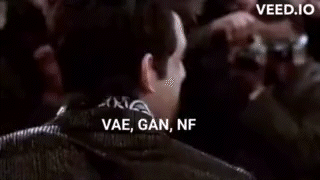

## Рассмотрим:
1. Процесс добавление шума к данным
2. Обучение диффузионной модели
3. Теорию выборки
4. Сравним нашу дифузию с Denoising Diffusion Probabilistic Models (DDPM) дифузией
5. Реализуем Class-Conditioned дифузию

## Устанавливаем зависимости

In [ ]:
!pip install -q diffusers wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Данные

В данном семинаре мы будем использовать данные MNIST. Если ваши глаза больше не могут смотреть на цифры, то можете использовать FashionMNIST не меняя код.

In [ ]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([6, 6, 9, 7, 7, 2, 5, 7])


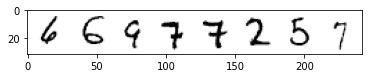

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## 1. Процесс добавление шума к данным

Представим, что мы просто хотим с какой-то долей зашумлять наши данные. В идеале контролировать процесс зашумления наших данных. Как бы мы это делали? 

Введем переменную `amount`, которая будет отвечать именно за количество зашумления. То есть по сути это будет выглядеть так:
```
noise = torch.rand_like(x)
noisy_x = (1-amount)*x + amount*noise
```
Легко заметить, что при `amount=0` никакого итогового зашумления не будет, при `amount=1` мы полностью зашумим наше изначальное x. Смешивая входные данные с шумом таким образом, мы сохраняем выходные данные в том же диапазоне (от 0 до 1) - что важно для наших данных.




In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

Посмотрим на этот процесс постепенного зашумления

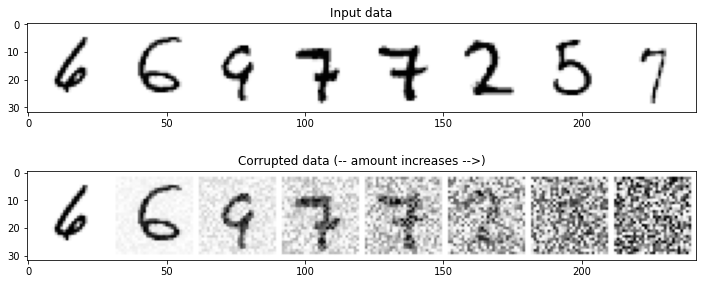

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plottinf the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## 2. Обучение диффузионной модели

### Модель

Будем использовать как модель нам уже известную сильно упрощенную UNet модель, с которой мы знакомились в прошлом курсе. Архитектура в нашем случае будет выглядеть так:

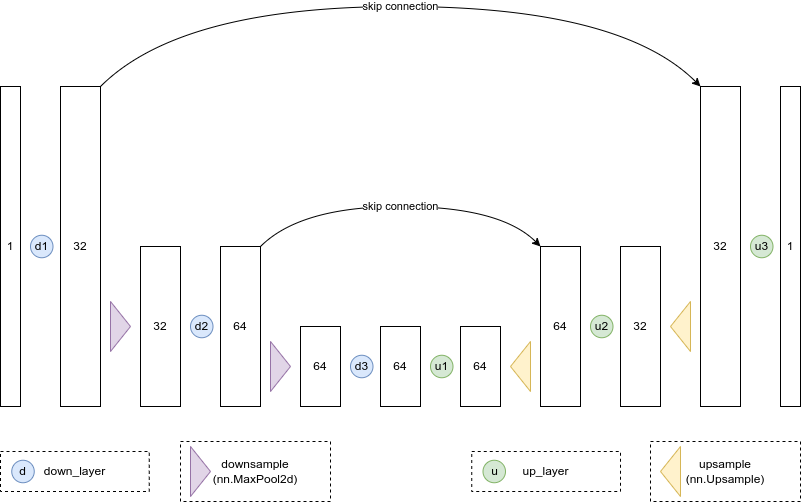

In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

Проверим наши выходы и количество параметров:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [ ]:
print(f"Количество параметров в сети: {sum([p.numel() for p in net.parameters()])}")

Количество параметров в сети: 309057


### Обучение


Однако мы все еще не затронули самый важный момент. Как же обучается это все вместе?

В нашем простом случае мы хотим, чтобы учитывая искаженный входной параметр `noisy_x`, модель должна вывести наилучшее предположение о том, как выглядит исходный `x`. Мы сравним это с фактическим значением через среднеквадратичную ошибку.

Finished epoch 0. Average loss for this epoch: 0.025886
Finished epoch 1. Average loss for this epoch: 0.019921
Finished epoch 2. Average loss for this epoch: 0.018315


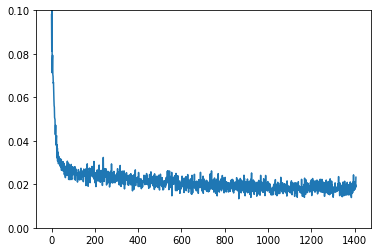

In [ ]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

Давайте посмотрим на то, как модель справляется с шумом. 

Посмотрим на `input-corrupted-prediciton` изображения:

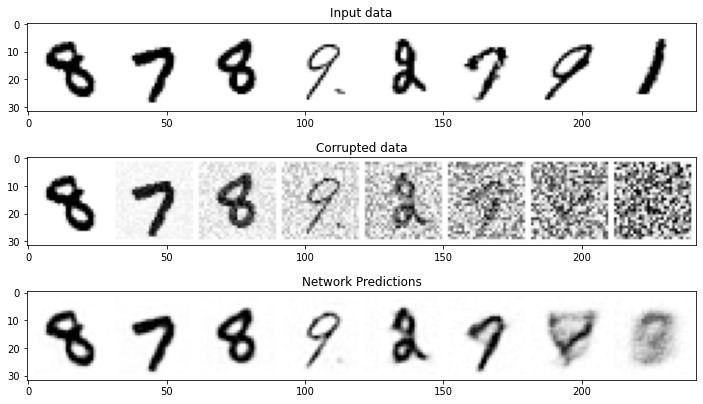

In [ ]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

Бросается в глаза, что модель:
1. Достаточно легко и быстро улавливает основные закономерности и до какого-то момента неплохо денойзит
2. На большом уровне зашумленности получается абсолютно непонятно что.

## 3. Теория выборки (Sampling)

Как мы видим, что при сильной зашумленности предсказания модели сильно непонятно. Что делать в таком случае?

Мы можем попробовать начать со случайного шума, посмотрим на прогнозы модели, а затем лишь немного продвинемся к этому прогнозу — скажем, на `20%`. Теперь у нас есть очень зашумленное изображение, в котором, возможно, есть намек на структуру, которую мы можем передать в модель, чтобы получить новый прогноз. Мы надеемся, что этот новый прогноз немного лучше первого (поскольку наша начальная точка немного менее зашумлена), и поэтому мы можем сделать еще один небольшой шаг с этим новым, лучшим прогнозом.

Повторить несколько раз и (если все пойдет хорошо) мы получим изображение! Вот этот процесс, проиллюстрированный всего за 5 шагов, с визуализацией входных данных модели (слева) и прогнозируемых изображений с шумоподавлением (справа) на каждом этапе. 

Обратите внимание, что даже несмотря на то, что модель предсказывает изображение с шумоподавлением даже на шаге 1, мы перемещаем туда только `x` часть. Через несколько шагов структуры появляются и уточняются, пока мы не получим наши окончательные результаты.

**Если тезисно:**
* Начинаем со случайного шума
* Смотрим на прогнозы модели, добавляем к ним меньше шума от предыдущего и опять подаем в модель
* Удивительно! (или нет) Но прогноз модели становится более конкретным. Повторяем предыдущий шаг сколько-то раз. 


Давайте теперь посмотрим, как это выглядит в нашем случае!

Попробуем сначала поэтапно посмотреть процесс с 5 шагов:

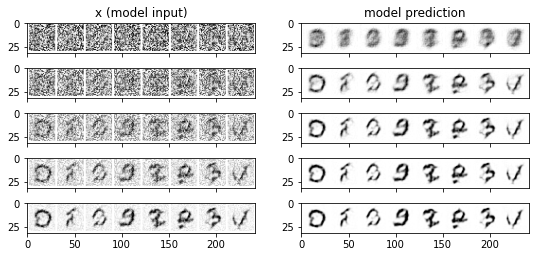

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

Теперь давайте увеличим количество шагов до 40! 
И посмотрим только на генерации:

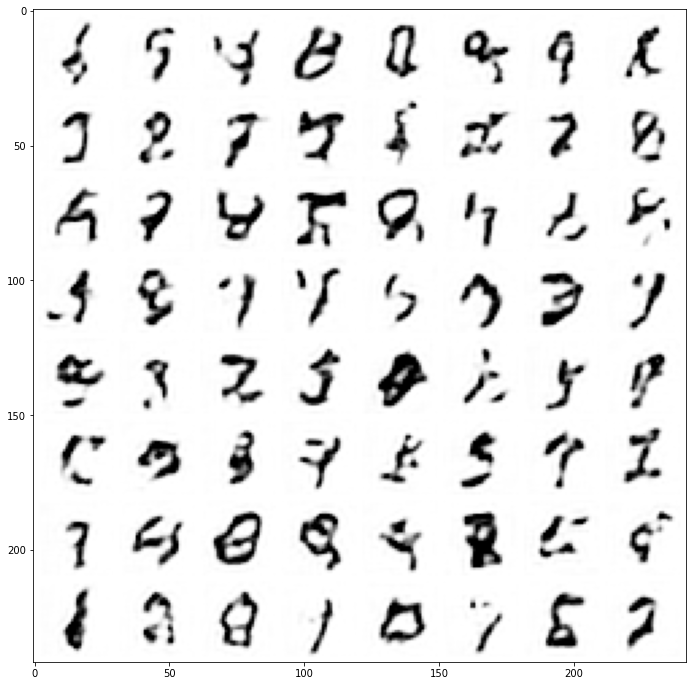

In [ ]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Когда семинаристы опять пытаются из каракуль доказать, что генерация отличная:
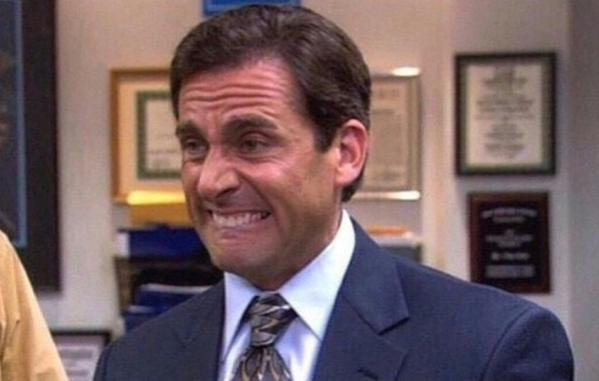

Скажем так. Не прекрасно прямо, но и не ужасно. Особенно стоит взять во внимание, что мы взяли очень легкую модель + всего пару эпох обучения, которые обучились меньше чем за минуту. Увеличив мощности мы будем получать точно лучше результаты

## 4. Сравним нашу дифузию с Denoising Diffusion Probabilistic Models (DDPM) дифузией

Сравним нашу игрушечную имплементацию с статейной Denoising Diffusion Probabilistic Models (DDPM) ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)).




*   Они испольузуют `UNet2DModel`, которая и больше и хитрее, чем наша BasicUNet
*   По-другому сделан процесс зашумления (corruption process)
* Цель обучения другая, она включает прогнозирование шума, а не изображения с шумоподавлением
* Модель обусловлена ​​количеством шума, присутствующего посредством обработки временного шага, где t передается в качестве дополнительного аргумента `forward` методу.
*   Доступен ряд различных sampling стратегий, которые должны работать лучше, чем наша упрощенная версия выше.

После выхода статьи о DDPM было предложено несколько улучшений, но мы надеемся, что этот пример является поучительным в отношении различных доступных дизайн решений. После того, как вы прочтете это, вам, возможно, понравится погрузиться в статью. ['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364) в котором подробно рассматриваются все эти компоненты и даются новые рекомендации о том, как добиться наилучшей производительности. 

### Модель из статьи

In [ ]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

Мы можем воспроизвести обучение, о котором написали выше, используя эту модель из статьи вместо нашей исходной. Нам нужно передать в модель как `x`, так и временной шаг (здесь я всегда передаю `t=0`, чтобы показать, что она работает без этого условия временного шага, и упростить код выборки, но вы также можете попробовать ввести `(amount*1000)`).

Finished epoch 0. Average loss for this epoch: 0.019385
Finished epoch 1. Average loss for this epoch: 0.013010
Finished epoch 2. Average loss for this epoch: 0.011853


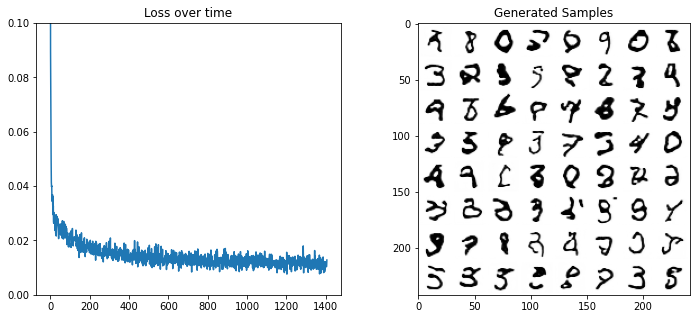

In [ ]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

Уже как будто намного лучше! Лосс подтверждает

In [ ]:
from IPython.display import Image
Image(url='https://i.kym-cdn.com/photos/images/original/002/036/007/9bd.gif')

## Отступление. Несколько моментов по статье

### Процесс зашумления (The Corruption Process)

В статье DDPM описывается процесс зашумления, который добавляет небольшое количество шума для каждого «временного шага». Учитывая $x_{t-1}$ для некоторого временного шага, мы можем получить следующую (чуть более шумную) версию $x_t$ с помощью:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x} _{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t -1})$<br><br>


То есть мы берем $x_{t-1}$, масштабируем его на $\sqrt{1 - \beta_t}$ и добавляем шум, масштабированный на $\beta_t$. Этот $\beta$ определяется для каждого t в соответствии с некоторым расписанием и определяет, сколько шума добавляется за каждый временной шаг. Теперь нам не нужно выполнять эту операцию 500 раз, чтобы получить $x_{500}$, поэтому у нас есть другая формула для получения $x_t$ для любого заданного t $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$, где $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ и $\alpha_i = 1-\beta_i$<br><br>

Выглядит страшно! К счастью, планировщик обрабатывает все это за нас. Мы можем построить $\sqrt{\bar{\alpha}_t}$ (помеченный как `sqrt_alpha_prod`) и $\sqrt{(1 - \bar{\alpha}_t)}$ (помеченный как `sqrt_one_minus_alpha_prod`) для просмотра как вход (x) и шум масштабируются и смешиваются на разных временных интервалах:

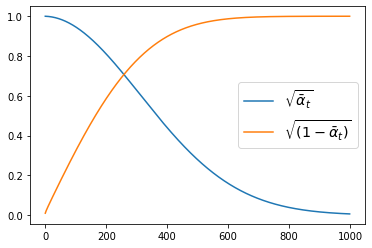

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) # Задаем наш scheduler
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Первоначально зашумленный x в основном равен x (sqrt_alpha_prod ~= 1), но со временем вклад x падает, а шумовая составляющая увеличивается. В отличие от нашего линейного сочетания x и шума в зависимости от «количества», этот зашумляется относительно быстро.

Выглядит это вот так:

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


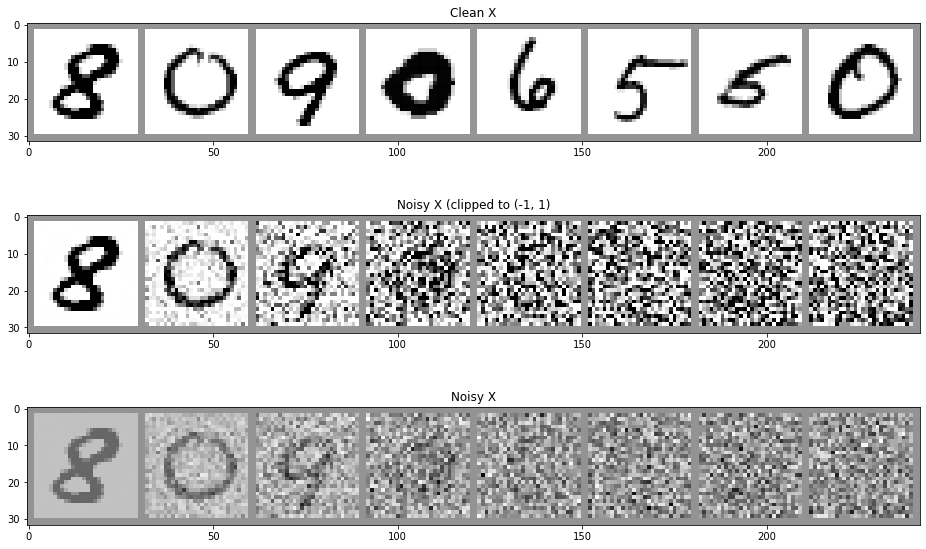

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

Кроме того, DDPM добавляет шум, взятый из распределения Гаусса (среднее значение 0, стандартное отклонение 1 из torch.randn), а не равномерный шум между 0 и 1 (из torch.rand), который мы использовали в нашей исходной «поврежденной» функции. В общем случае имеет смысл нормализовать и обучающие данные.

### Обучение

В нашем игрушечном примере модель пыталась предсказать изображение без шума. В DDPM и многих других реализациях диффузионной модели модель предсказывает шум, используемый в процессе искажения (до масштабирования, поэтому шум единичной дисперсии). В коде это выглядит примерно так:

```python
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise as the target
```

Вы можете подумать, что прогнозирование шума (из которого мы можем вывести, как выглядит изображение с шумоподавлением) эквивалентно простому прогнозированию изображения с шумоподавлением напрямую. **Так зачем отдавать предпочтение одному перед другим — это просто для математического удобства?**

Оказывается, здесь есть еще одна тонкость. Мы вычисляем потери на разных (случайно выбранных) временных шагах во время обучения. Эти разные цели приведут к различному «неявному взвешиванию» этих потерь, когда прогнозирование шума придает больший вес более низким уровням шума. Вы можете выбрать более сложные цели, чтобы изменить это «неявное взвешивание потерь». Или, возможно, вы выберете график шума, который приведет к большему количеству примеров с более высоким уровнем шума.

На данный момент прогнозирование шума (эпсилон или эпсилон, который вы увидите в некоторых местах) является предпочтительным подходом, но со временем мы, вероятно, увидим другие цели, поддерживаемые в библиотеке и используемые в различных ситуациях.


### Временной шаг (timestamp conditioning)

UNet2DModel принимает как x, так и временной шаг. Последнее превращено в эмбединги и в ряде мест передается в модель.

**Теория, лежащая в основе этого, заключается в том, что, предоставляя модели информацию об уровне шума, она может лучше выполнять свою задачу**. Несмотря на то, что можно обучить модель без этого условия временного шага, кажется, что в некоторых случаях это помогает повысить производительность, и большинство реализаций включают его, по крайней мере, в сегодня.

## 5. Реализуем Class-Conditioned дифузию

In [ ]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

100%|██████████| 469/469 [01:54<00:00,  4.08it/s]


Finished epoch 0. Average of the last 100 loss values: 0.052152


100%|██████████| 469/469 [01:54<00:00,  4.09it/s]


Finished epoch 1. Average of the last 100 loss values: 0.046410


100%|██████████| 469/469 [01:54<00:00,  4.10it/s]


Finished epoch 2. Average of the last 100 loss values: 0.044082


100%|██████████| 469/469 [01:53<00:00,  4.11it/s]


Finished epoch 3. Average of the last 100 loss values: 0.042120


100%|██████████| 469/469 [01:53<00:00,  4.13it/s]


Finished epoch 4. Average of the last 100 loss values: 0.042145


100%|██████████| 469/469 [01:49<00:00,  4.28it/s]


Finished epoch 5. Average of the last 100 loss values: 0.040433


100%|██████████| 469/469 [01:51<00:00,  4.20it/s]


Finished epoch 6. Average of the last 100 loss values: 0.039865


100%|██████████| 469/469 [01:51<00:00,  4.22it/s]


Finished epoch 7. Average of the last 100 loss values: 0.039313


100%|██████████| 469/469 [01:53<00:00,  4.15it/s]


Finished epoch 8. Average of the last 100 loss values: 0.039267


100%|██████████| 469/469 [01:54<00:00,  4.09it/s]


Finished epoch 9. Average of the last 100 loss values: 0.038719


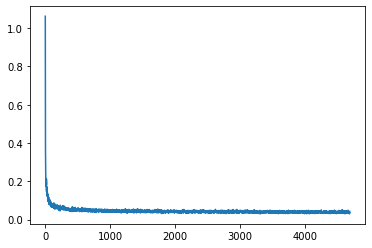

In [ ]:
from tqdm import tqdm
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

1000it [00:43, 23.03it/s]


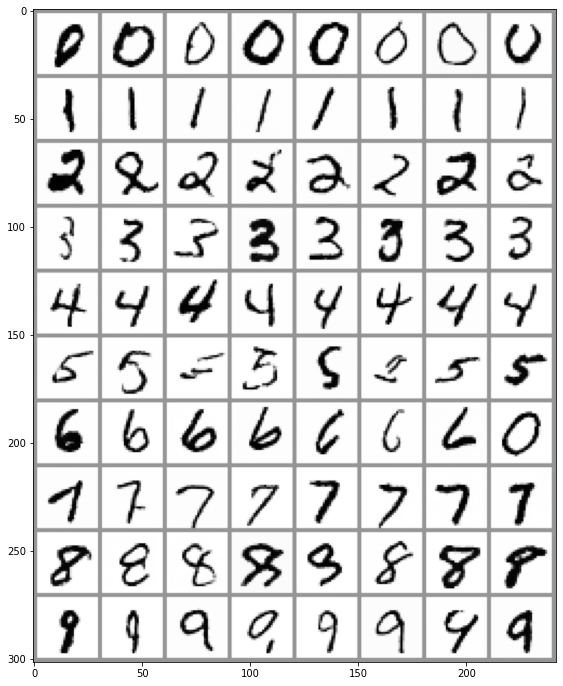

In [ ]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

Теперь вся власть в наших руках и мы можем заставить модель генерировать цифру, которую мы хотим!

In [ ]:
Image(url='https://media.tenor.com/Vr5oMNMnNJIAAAAS/vince-vince-mcmahon.gif')